# Digital Methods - Dictionary Classifier
_____

## Table of Content

1. [Libraries](#libraries)
2. [Load Data](#load-data)
3. [Data Preprocessing](#preprocessing-of-the-data)
4. [Set Up of Dictionary](#building-dictionary)
5. [Classifier](#classifier)
6. [Networks](#network-analysis)
7. [Backtracking Uncategorized Comments](#tracking-uncategorized-comments)
_____

## Libraries

All libraries which are needed to execute the code are listed here. Install the packages by using the `requirements.txt` file. 

The documentation can be found in the [README.md](README.md) file.

In [49]:
# import packages
import pandas as pd 
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams
from preprocessing_functions import *
from collections import defaultdict
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from googleapiclient.discovery import build

#import script --- CREATING SCRIPT TO IMPORT YouTube API KEY ---
from api_key import api_key_1

## Load Data

Load collected YouTube comments from the Data Collection.

In [50]:
df = pd.read_csv('data/comments_final.csv')

In [51]:
# process data with using functions from functions.py
processed_df = (
    df.pipe(remove_users, 'text')
      .pipe(lowercase_text, 'text')
      .pipe(remove_whitespace, 'text')
      .pipe(remove_punctuation, 'text')
)

# Preprocessing of the Data

- Stemming and Lemmatizing
- Tokenization of the comments
- Building N-grams

In [52]:
# text column to string
processed_df['text'] = processed_df['text'].astype('str')
processed_df['text'] = processed_df['text'].str.replace('\'', '')

# use stemming to reduce words to their root words
processed_df = stem_words(processed_df, 'text')

# use lemmatization to reduce words to their root form
processed_df = lemmatize_words(processed_df, 'text')

# convert date format
processed_df = convert_date_format(processed_df, 'published_at')

In [53]:
#dropping the na from lemmatized & stemmed text to avoid issues with creating n_grams
processed_df.lemmatized_text = processed_df.lemmatized_text.apply(lambda x: '' if str(x) == 'nan' else x)
processed_df.stemmed_text = processed_df.stemmed_text.apply(lambda x: '' if str(x) == 'nan' else x)

In [54]:
# Tokenizing the lemmatized and stemmed text before creating n-grams
def tokenize_words(text):
    words = word_tokenize(text)
    #words_with_quotes = [f"'{word}'" for word in words]
    return words

processed_df["stemmed_tokens"] = processed_df["stemmed_text"].apply(lambda x: tokenize_words(x))
processed_df["lemmatized_tokens"] = processed_df["lemmatized_text"].apply(lambda x: tokenize_words(x))

In [55]:
# Creating n-grams 
tqdm.pandas() #Creates a progress bar and below use "progress_apply" instead of "apply" to create a progress bar (This is more of a "nice to have" than a "need to have")

#Defining a function that will create bigrams 
def bigrams(doc): # a doc is a list of tokens/unigrams in same order as in tweets 
    
    bigrams = [] #Empty list to save the bigrams
    
    for bigram in list(nltk.bigrams(doc)):  #Creating bigrams as tuples with nltk.bigrams and iterating over these them
        bigrams.append("_".join(bigram))    #Joining each bigram-tuple pair with an underscore and saving to list
    
    return bigrams

#Defining a function that will create bigrams 
def trigrams(doc): # a doc is a list of unigrams in same order as in tweets 
    
    trigrams = [] #Empty list to save the bigrams
    
    for trigram in list(nltk.trigrams(doc)):  #Creating bigrams as tuples with nltk.bigrams and iterating over these them
        trigrams.append("_".join(trigram))    #Joining each bigram-tuple pair with an underscore and saving to list
    
    return trigrams

#Defining a function that will create bigrams 
def fourgrams(doc): # a doc is a list of unigrams in same order as in tweets 
    
    fourgrams = [] #Empty list to save the bigrams
    
    for fourgram in list(ngrams(doc, 4)):  #Creating bigrams as tuples with nltk.bigrams and iterating over these them
        fourgrams.append("_".join(fourgram))    #Joining each bigram-tuple pair with an underscore and saving to list
    
    return fourgrams

#Creating a column with bigrams by applying function to column of unigrams
processed_df['bigrams_lemma'] = processed_df["lemmatized_tokens"].progress_apply(lambda x: bigrams(x))
processed_df['trigrams_lemma'] = processed_df['lemmatized_tokens'].progress_apply(lambda x : trigrams(x))
processed_df['fourgrams_lemma'] = processed_df['lemmatized_tokens'].progress_apply(lambda x : fourgrams(x))

processed_df['bigrams_stem'] = processed_df["stemmed_tokens"].progress_apply(lambda x: bigrams(x))
processed_df['trigrams_stem'] = processed_df['stemmed_tokens'].progress_apply(lambda x : trigrams(x))
processed_df['fourgrams_stem'] = processed_df['stemmed_tokens'].progress_apply(lambda x : fourgrams(x))


100%|██████████| 96595/96595 [00:00<00:00, 128509.41it/s]


In [56]:
# creating one column with all n-grams (unigrams, bigrams, trigrams, fourgrams)
processed_df["all_n_grams_lemmatized"] = processed_df["lemmatized_tokens"] + processed_df["bigrams_lemma"] + processed_df["trigrams_lemma"] + processed_df["fourgrams_lemma"]
processed_df["all_n_grams_stemmed"] = processed_df["stemmed_tokens"] + processed_df["bigrams_stem"] + processed_df["trigrams_stem"] + processed_df["fourgrams_stem"]

In [57]:
def contains_climate(lst):
    return 'climate' in lst

# Applying the function to create a boolean mask
climate_mask = processed_df['all_n_grams_lemmatized'].apply(contains_climate)

# Summing the rows where the mask is True
sum_rows_with_climate = climate_mask.sum()

print(f"Number of rows containing 'climate': {sum_rows_with_climate}")

Number of rows containing 'climate': 14821


## Building Dictionary

Building the Dictionary for the Classifier. This process is based on the qualitative research and Word2Vec Model + Topic Modelling.

In [71]:
# Creating Dictionary 

sc1_kw = ['no_climate_emergency', 'melting', 'arctic_ice', 'arctic_sea ice', 'sea_level_rise', 'extreme_weather', 'global_cooling', 'greenland_ice',
          'ice_cap', 'arctic_ice', 'extreme_heat', 'extreme_cold' ]
# unsure &  included: 'melting'
# unsure & not included: 'glacier', 'wildfires', 'climate emergency', 'unproven', 'global warming'

sc2_kw = ['natural_cycle', 'CO2_is_not_the_cause', 'greenhouse_gas', 'no_CO2_Greenhouse_Effect', 'no_effect', 'miniscule_effect', 'Man_has_no_control']
# unsure & not included: 'natural process'

sc3_kw = ['plant_food', 'plant_growth', 'thrive', 'carbon_element_is_essential', 'average_temperature_increase', '1_degree', 
          'more_fossil_fuels', 'no_co2', 'plant_food', 'not_pollution', '0.1C', 'ppm', 'not_a_pollutant']
# unsure & not included: 'beneficial'

sc4_kw = ['green_energy', 'renewable_energy', 'energy_production', 'windmills', 'solar_panel']
# unsure &  included: 'renewable energy'

sc5_kw = ['alarmism', 'catastrophist', 'doomsday_cult', 'climate_hysteric', 'unscientific', 'corrupt_politician', 'LIE_ABOUT_EVERYTHING',
          'idiocy', 'lunatics', 'CLIMATE_Worship', 'Climatists', 'alarmists', 'compliant_media', 'climate_hysteria', 'climate_narrative', 'climate_cult',
             'scientism', 'climate_science_myths', 'lying_in_science', 'climate_apocalypse', 'propaganda', 'doomsayers', 'clown_show', 'fake_climate',
               'climate_change_agenda', 'money_made', 'fake_news', 'climate_terrorists']
# unsure & not included: 'scientist', 'global warming scam' (could also be sc7), 'greta', 'john kerry'

sc7_kw = ['globalist', 'globalist_elites', 'elitist', 'global_government', 'one_world', 'one_world_government', 'globalism', 
          'one_world_utopia', 'new_world_order', 'enriching_themselves', 'saving_the_planet', 'control_over_your_lives', 
          'tyranny', 'global_elite', 'wef', 'population_control']
# unsure & included: 'tyranny', 'population control'
# unsure & not included: 'totalitarian'

In [59]:
# lowercase and stemming/lemmatizing the keyword lists 

# Function to remove underscores and convert to lowercase
def preprocess_keywords(keywords):
    return [keyword.replace('_', ' ').lower() for keyword in keywords]

# Stem words
def stem_words(words):
    stemmer = SnowballStemmer(language='english')
    return [" ".join([stemmer.stem(word) for word in word_tokenize(keyword)]) for keyword in words]

# Lemmatize words
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    
    # Mapping NLTK POS tags to WordNet POS tags
    tag_map = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'R': wordnet.ADV,
        'N': wordnet.NOUN
    }
    
    lemmatized_keywords = []
    for keyword in words:
        tokens = word_tokenize(keyword)
        pos_tags = pos_tag(tokens)
        lemmatized_tokens = [lemmatizer.lemmatize(word, tag_map.get(tag[0], wordnet.NOUN)) for word, tag in pos_tags]
        lemmatized_keywords.append(" ".join(lemmatized_tokens))
    
    return lemmatized_keywords


# Replacing the whitespaces with underscores again to create n-grams
def postprocess_keywords(keywords):
    return [keyword.replace(' ', '_') for keyword in keywords]

# Apply the preprocessing, stemming, and lemmatization
sc1_kw_lemmatized = postprocess_keywords(lemmatize_words(preprocess_keywords(sc1_kw)))
sc2_kw_lemmatized = postprocess_keywords(lemmatize_words(preprocess_keywords(sc2_kw)))
sc3_kw_lemmatized = postprocess_keywords(lemmatize_words(preprocess_keywords(sc3_kw)))
sc4_kw_lemmatized = postprocess_keywords(lemmatize_words(preprocess_keywords(sc4_kw)))
sc5_kw_lemmatized = postprocess_keywords(lemmatize_words(preprocess_keywords(sc5_kw)))
sc7_kw_lemmatized = postprocess_keywords(lemmatize_words(preprocess_keywords(sc7_kw)))

sc1_kw_stemmed = postprocess_keywords(stem_words(preprocess_keywords(sc1_kw)))
sc2_kw_stemmed = postprocess_keywords(stem_words(preprocess_keywords(sc2_kw)))
sc3_kw_stemmed = postprocess_keywords(stem_words(preprocess_keywords(sc3_kw)))
sc4_kw_stemmed = postprocess_keywords(stem_words(preprocess_keywords(sc4_kw)))
sc5_kw_stemmed = postprocess_keywords(stem_words(preprocess_keywords(sc5_kw)))
sc7_kw_stemmed = postprocess_keywords(stem_words(preprocess_keywords(sc7_kw)))

# print lemmatized dictionary
print("sc1_kw_lemmatized:", sc1_kw_lemmatized)
print("sc2_kw_lemmatized:", sc2_kw_lemmatized)
print("sc3_kw_lemmatized:", sc3_kw_lemmatized)
print("sc4_kw_lemmatized:", sc4_kw_lemmatized)
print("sc5_kw_lemmatized:", sc5_kw_lemmatized)
print("sc7_kw_lemmatized:", sc7_kw_lemmatized)

# print stemmed dictionary
print("sc1_kw_stemmed:", sc1_kw_stemmed)
print("sc2_kw_stemmed:", sc2_kw_stemmed)
print("sc3_kw_stemmed:", sc3_kw_stemmed)
print("sc4_kw_stemmed:", sc4_kw_stemmed)
print("sc5_kw_stemmed:", sc5_kw_stemmed)
print("sc7_kw_stemmed:", sc7_kw_stemmed)

sc1_kw_lemmatized: ['no_climate_emergency', 'melt', 'arctic_ice', 'arctic_sea_ice', 'sea_level_rise', 'extreme_weather', 'global_cooling', 'greenland_ice', 'ice_cap', 'arctic_ice', 'extreme_heat', 'extreme_cold']
sc2_kw_lemmatized: ['natural_cycle', 'co2_be_not_the_cause', 'greenhouse_gas', 'no_co2_greenhouse_effect', 'no_effect', 'miniscule_effect', 'man_have_no_control']
sc3_kw_lemmatized: ['plant_food', 'plant_growth', 'thrive', 'carbon_element_be_essential', 'average_temperature_increase', '1_degree', 'more_fossil_fuel', 'no_co2', 'plant_food', 'not_pollution', '0.1c', 'ppm', 'not_a_pollutant']
sc4_kw_lemmatized: ['green_energy', 'renewable_energy', 'energy_production', 'windmill', 'solar_panel']
sc5_kw_lemmatized: ['alarmism', 'catastrophist', 'doomsday_cult', 'climate_hysteric', 'unscientific', 'corrupt_politician', 'lie_about_everything', 'idiocy', 'lunatic', 'climate_worship', 'climatists', 'alarmist', 'compliant_medium', 'climate_hysteria', 'climate_narrative', 'climate_cult',

In [60]:
# Creating the dictionaries for the classifier
keyword_dict_lemmatized = {
    1: sc1_kw_lemmatized,
    2: sc2_kw_lemmatized,
    3: sc3_kw_lemmatized,
    4: sc4_kw_lemmatized,
    5: sc5_kw_lemmatized,
    6: sc7_kw_lemmatized
}


keyword_dict_stemmed = {
    1: sc1_kw_stemmed,
    2: sc2_kw_stemmed,
    3: sc3_kw_stemmed,
    4: sc4_kw_stemmed,
    5: sc5_kw_stemmed,
    6: sc7_kw_stemmed
}

keyword_dict_lemmatized_valid = {
    1: ['climate'],
    2: ['climate_change']
}

#print keyword dictionaries
print(keyword_dict_lemmatized)
print(keyword_dict_stemmed)

{1: ['no_climate_emergency', 'melt', 'arctic_ice', 'arctic_sea_ice', 'sea_level_rise', 'extreme_weather', 'global_cooling', 'greenland_ice', 'ice_cap', 'arctic_ice', 'extreme_heat', 'extreme_cold'], 2: ['natural_cycle', 'co2_be_not_the_cause', 'greenhouse_gas', 'no_co2_greenhouse_effect', 'no_effect', 'miniscule_effect', 'man_have_no_control'], 3: ['plant_food', 'plant_growth', 'thrive', 'carbon_element_be_essential', 'average_temperature_increase', '1_degree', 'more_fossil_fuel', 'no_co2', 'plant_food', 'not_pollution', '0.1c', 'ppm', 'not_a_pollutant'], 4: ['green_energy', 'renewable_energy', 'energy_production', 'windmill', 'solar_panel'], 5: ['alarmism', 'catastrophist', 'doomsday_cult', 'climate_hysteric', 'unscientific', 'corrupt_politician', 'lie_about_everything', 'idiocy', 'lunatic', 'climate_worship', 'climatists', 'alarmist', 'compliant_medium', 'climate_hysteria', 'climate_narrative', 'climate_cult', 'scientism', 'climate_science_myth', 'lie_in_science', 'climate_apocalypse

## Classifier

Classification of YouTube comments related to each claim, based on the text of the comment.

In [61]:
# Classifiying the comments into categories
def classify_comments(comments, keyword_dict):
    classifications = [] #initialize empty list of classifications
    
    for comment in comments: #loop through each comment of the df 
        categories = [] #initialize empty list of categories
        comment_str = ",".join(comment)  # Join the tokens of one comement into a single string for easier matching
        
        for category, keywords in keyword_dict.items(): #iterating through each key-value pair of the dictionary
            for keyword in keywords: #for each category: iterate through list of keywords. Check if each keyword is present in comment_str
                if keyword in comment_str:
                    categories.append(category) #if a keyworrd is found, the category is appended to list.
                    break  # Stop checking more keywords for this category
        
        if not categories:
            categories = ['uncategorized']
        
        classifications.append(categories)
    
    return classifications

# Apply classifier to lemmatized comments 
processed_df['category_lemmatized_comments'] = classify_comments(processed_df['all_n_grams_lemmatized'], keyword_dict_lemmatized)


In [62]:
# Categories Count of Lemmatized Unigrams
processed_df['category_lemmatized_comments'].value_counts()

category_lemmatized_comments
[uncategorized]    88626
[5]                 2957
[6]                 1891
[1]                 1083
[4]                  580
[3]                  571
[2]                  296
[5, 6]               141
[1, 5]                72
[3, 5]                51
[1, 3]                42
[2, 3]                38
[3, 6]                30
[4, 5]                28
[1, 6]                28
[1, 2]                25
[2, 5]                18
[1, 4]                18
[4, 6]                16
[3, 4]                11
[2, 4]                10
[1, 3, 5]              9
[1, 2, 3, 5]           7
[2, 6]                 7
[1, 5, 6]              5
[1, 2, 3]              5
[2, 3, 5]              5
[1, 2, 5]              4
[2, 3, 5, 6]           4
[1, 3, 6]              3
[1, 3, 4, 6]           3
[1, 2, 6]              2
[2, 5, 6]              1
[1, 2, 4]              1
[3, 5, 6]              1
[1, 2, 3, 4, 5]        1
[2, 3, 4]              1
[1, 3, 4, 5]           1
[1, 2, 3, 5, 6]      

In [63]:
# Categories of Validation with Climate and Climate Change
processed_df['category_lemmatized_comments_validated'] = classify_comments(processed_df['all_n_grams_lemmatized'], keyword_dict_lemmatized_valid)
print(processed_df['category_lemmatized_comments_validated'].value_counts())

category_lemmatized_comments_validated
[uncategorized]    81518
[1]                 7795
[1, 2]              7282
Name: count, dtype: int64


## Network Analysis

Building a network for the interconnected Claims based on the Fruchterman-Reingold algorithm

In [64]:
# filter interconnected claims
processed_df_network = processed_df[['category_lemmatized_comments','author', 'video_id']]
processed_df_network = processed_df_network[~processed_df_network['category_lemmatized_comments'].apply(lambda x: 'uncategorized' in x)]

In [65]:
# Initialize a dictionary to hold co-occurrence counts
co_occurrence = defaultdict(int)

# Iterate over the DataFrame
for categories in processed_df_network['category_lemmatized_comments']:
    for category_pair in itertools.combinations(categories, 2):
        co_occurrence[tuple(sorted(category_pair))] += 1

# Convert the co-occurrence dictionary to a DataFrame (adjacency matrix)
adj_matrix = pd.DataFrame.from_dict(co_occurrence, orient='index', columns=['weight'])
adj_matrix = adj_matrix.reset_index()
adj_matrix[['category1', 'category2']] = pd.DataFrame(adj_matrix['index'].tolist(), index=adj_matrix.index)
adj_matrix = adj_matrix.drop(columns='index')

In [66]:
# Create the graph
G = nx.Graph()

# Add edges with weights
for _, row in adj_matrix.iterrows():
    G.add_edge(row['category1'], row['category2'], weight=row['weight'])

# Optional: Add nodes for categories with no edges
for category in processed_df_network['category_lemmatized_comments'].explode().unique():
    if category not in G:
        G.add_node(category)

print(G.nodes())
print(G.edges(data=True))

[1, 4, 3, 5, 6, 2]
[(1, 4, {'weight': 24}), (1, 3, {'weight': 72}), (1, 6, {'weight': 42}), (1, 2, {'weight': 46}), (1, 5, {'weight': 100}), (4, 5, {'weight': 31}), (4, 6, {'weight': 20}), (4, 3, {'weight': 18}), (4, 2, {'weight': 14}), (3, 5, {'weight': 80}), (3, 6, {'weight': 43}), (3, 2, {'weight': 62}), (5, 6, {'weight': 153}), (5, 2, {'weight': 42}), (6, 2, {'weight': 15})]


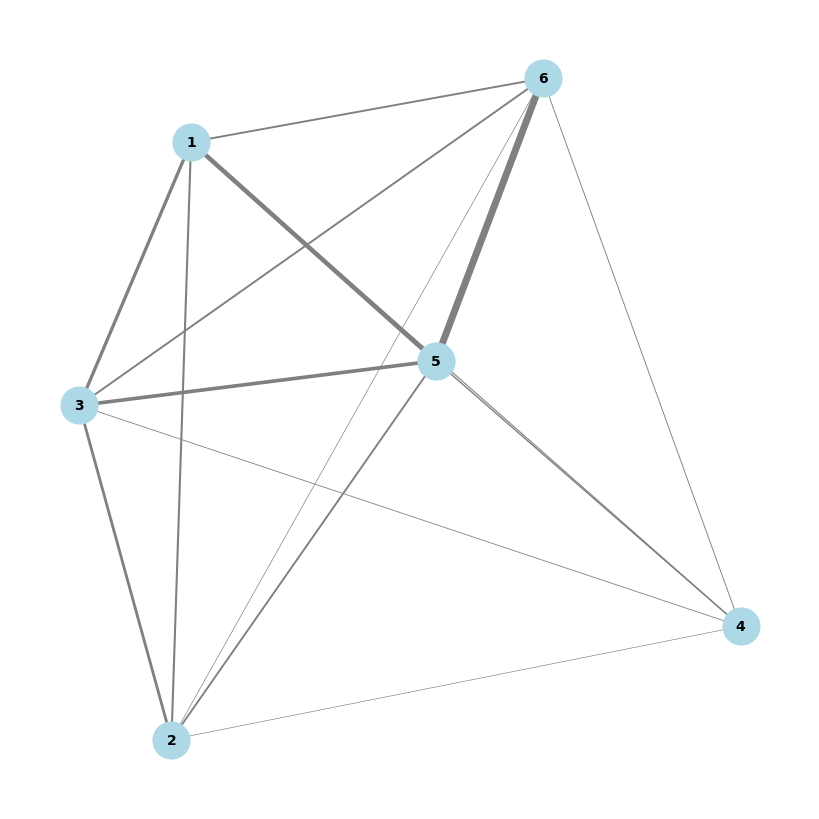

In [67]:
# Compute positions using the Fruchterman-Reingold algorithm
pos = nx.spring_layout(G, seed=42)  # seed for reproducibility

# Extract edge weights
edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]

# Normalize edge weights for better visualization
max_weight = max(edge_weights)
edge_widths = [w / max_weight * 5 for w in edge_weights]  # Scaling factor (5) can be adjusted as needed

# Draw the graph
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', 
        width=edge_widths, edge_color='gray')  # Specify edge width

plt.axis('off')  # Turn off axis
plt.show()


## Tracking Uncategorized Comments

to find out why many of the comments are uncategorized we backtrack them to the channel to see if there is any relationship.
Based on the video id which we have for each comment we can use the YouTube API to get the channel name.

> **Important**: Insert your API Key in the Script

In [68]:
processed_df = processed_df[['category_lemmatized_comments', 'video_id']]
processed_df['category'] = processed_df['category_lemmatized_comments'].apply(lambda x: ', '.join(map(str, x)))
processed_df = processed_df[processed_df['category'] == 'uncategorized']
processed_df = processed_df.groupby('video_id')['category'].value_counts().reset_index(name='Category_Count')

/var/folders/0t/kqk1ph5n4ds0_g7v6gyknwdh0000gn/T/ipykernel_40937/581894756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['category'] = processed_df['category_lemmatized_comments'].apply(lambda x: ', '.join(map(str, x)))


In [69]:
# Replace with your API key
API_KEY = api_key_1
def get_channel_name(video_id):
    # Build the YouTube service object
    youtube = build('youtube', 'v3', developerKey=API_KEY)
    
    try:
        # Request video details
        video_response = youtube.videos().list(
            part='snippet',
            id=video_id
        ).execute()
        
        # Extract channel ID from video details
        channel_id = video_response['items'][0]['snippet']['channelId']
        
        # Request channel details
        channel_response = youtube.channels().list(
            part='snippet',
            id=channel_id
        ).execute()
        
        # Extract channel name from channel details
        channel_name = channel_response['items'][0]['snippet']['title']
        
        return channel_name
    
    except:
        return None  # Return None if there's an error

# Function to get channel name for each video ID
def get_channel_names(row):
    return get_channel_name(row['video_id'])

# Apply the function to each row in the DataFrame
processed_df['channel_name'] = processed_df.apply(get_channel_names, axis=1)

In [70]:
processed_df = processed_df.groupby('channel_name')['Category_Count'].sum().reset_index()
processed_df.sort_values('Category_Count',ascending=False,inplace=True)
processed_df

,channel_name,Category_Count
10,Tony Heller,30334
5,PowerfulJRE,12177
1,BlazeTV,11373
8,Redacted,8306
9,Tom Nelson,7138
6,PragerU,7032
2,Jordan B Peterson,6802
7,ReasonTV,1768
0,Blaze News,1577
4,Newsmax,1175
